In [16]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout


In [17]:
data_folder = 'data/'
data_folder_mass = 'data/MassModels/'
data = np.loadtxt(data_folder_mass+'NGC2403.NFW.fix.REV.dat', skiprows=12) 
df = pd.DataFrame(data, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])

In [18]:
N = len(df.values)
df.head()

,Radius,vgas,vdisk,vbulge,vobs,err_vobs,Vu,Vt,Rxv,Vxy
0,0.06252,-0.878,-1.02499,8.48001,1.98,6.926,12.9353,15.4081,0.0,0.0
1,0.12500,-1.771,4.32810,15.26710,15.78,7.691,18.2399,24.1117,0.0,0.0
2,0.18760,-2.740,8.67483,20.65930,22.30,4.584,22.2837,31.4820,0.0,0.0
3,0.25010,-3.448,12.47880,25.01450,32.16,4.542,25.6589,37.7881,0.0,0.0
4,0.31260,-3.847,16.36670,28.54780,39.67,4.433,28.6082,43.4336,0.0,0.0


In [19]:
df = df[['Radius', 'vobs','err_vobs', 'Vt']]
df.head()

,Radius,vobs,err_vobs,Vt
0,0.06252,1.98,6.926,15.4081
1,0.12500,15.78,7.691,24.1117
2,0.18760,22.30,4.584,31.4820
3,0.25010,32.16,4.542,37.7881
4,0.31260,39.67,4.433,43.4336


In [20]:
 df['Radius'].values

array([ 0.06252,  0.125  ,  0.1876 ,  0.2501 ,  0.3126 ,  0.3751 ,
        0.4377 ,  0.5002 ,  0.5627 ,  0.6252 ,  0.6878 ,  0.7503 ,
        0.8128 ,  0.8753 ,  0.9379 ,  1.     ,  1.063  ,  1.125  ,
        1.188  ,  1.25   ,  1.313  ,  1.376  ,  1.438  ,  1.501  ,
        1.563  ,  1.626  ,  1.688  ,  1.751  ,  1.813  ,  1.876  ,
        1.938  ,  2.001  ,  2.063  ,  2.126  ,  2.188  ,  2.251  ,
        2.313  ,  2.376  ,  2.438  ,  2.501  ,  2.563  ,  2.626  ,
        2.689  ,  2.751  ,  2.814  ,  2.876  ,  2.939  ,  3.001  ,
        3.064  ,  3.126  ,  3.189  ,  3.251  ,  3.314  ,  3.376  ,
        3.439  ,  3.501  ,  3.564  ,  3.626  ,  3.689  ,  3.751  ,
        3.814  ,  3.877  ,  3.939  ,  4.002  ,  4.064  ,  4.127  ,
        4.189  ,  4.252  ,  4.314  ,  4.377  ,  4.439  ,  4.502  ,
        4.564  ,  4.627  ,  4.689  ,  4.752  ,  4.814  ,  4.877  ,
        4.939  ,  5.002  ,  5.064  ,  5.127  ,  5.19   ,  5.252  ,
        5.315  ,  5.377  ,  5.44   ,  5.502  ,  5.565  ,  5.62

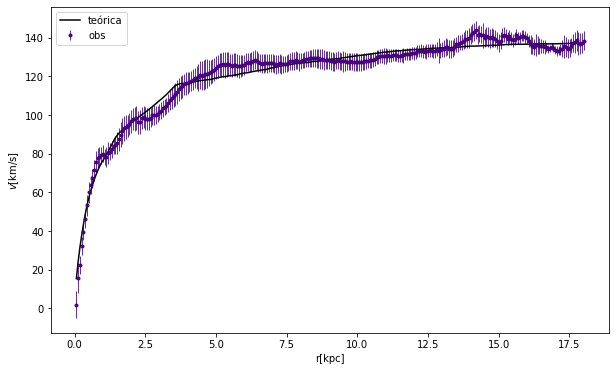

In [21]:
fig = plt.figure(figsize=(10, 6))
#plt.errorbar(mass_models[0].values, total['vrot'].values, yerr=total['err'].values, fmt='.', color='k', elinewidth=1, ecolor='green', label='total')
plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='indigo', elinewidth=1, ecolor='rebeccapurple', label='obs')
plt.plot(df['Radius'].values, df['Vt'].values, color='k', label='teórica')

plt.ylabel("$v$[km/s]")
plt.xlabel("r[kpc]")
plt.legend()

In [22]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:3]

In [23]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [24]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(y_train), np.shape(z_test), np.shape(y_test)

((230, 1), (230, 2), (58, 1), (58, 2))

In [25]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [26]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))


Epoch 1/1000
58/58 [==============================] - 1s 4ms/step - loss: 6936.6152 - val_loss: 4967.7188
Epoch 2/1000
58/58 [==============================] - 0s 2ms/step - loss: 1908.1816 - val_loss: 1003.7754
Epoch 3/1000
58/58 [==============================] - 0s 2ms/step - loss: 823.7102 - val_loss: 564.6724
Epoch 4/1000
58/58 [==============================] - 0s 2ms/step - loss: 603.6761 - val_loss: 463.3148
Epoch 5/1000
58/58 [==============================] - 0s 2ms/step - loss: 502.2717 - val_loss: 356.7725
Epoch 6/1000
58/58 [==============================] - 0s 2ms/step - loss: 394.9444 - val_loss: 254.4092
Epoch 7/1000
58/58 [==============================] - 0s 2ms/step - loss: 364.6133 - val_loss: 233.7705
Epoch 8/1000
58/58 [==============================] - 0s 2ms/step - loss: 307.7648 - val_loss: 353.2767
Epoch 9/1000
58/58 [==============================] - 0s 2ms/step - loss: 264.6575 - val_loss: 251.3699
Epoch 10/1000
58/58 [==============================] - 0s 2m

58/58 [==============================] - 0s 2ms/step - loss: 105.3461 - val_loss: 95.3150
Epoch 80/1000
58/58 [==============================] - 0s 2ms/step - loss: 93.6907 - val_loss: 85.1542
Epoch 81/1000
58/58 [==============================] - 0s 2ms/step - loss: 102.5674 - val_loss: 104.5999
Epoch 82/1000
58/58 [==============================] - 0s 2ms/step - loss: 97.9993 - val_loss: 117.2693
Epoch 83/1000
58/58 [==============================] - 0s 2ms/step - loss: 108.8223 - val_loss: 67.2356
Epoch 84/1000
58/58 [==============================] - 0s 2ms/step - loss: 130.7296 - val_loss: 75.1894
Epoch 85/1000
58/58 [==============================] - 0s 2ms/step - loss: 95.3926 - val_loss: 69.3038
Epoch 86/1000
58/58 [==============================] - 0s 2ms/step - loss: 97.0189 - val_loss: 99.3158
Epoch 87/1000
58/58 [==============================] - 0s 2ms/step - loss: 101.1767 - val_loss: 79.4969
Epoch 88/1000
58/58 [==============================] - 0s 2ms/step - loss: 105.6

58/58 [==============================] - 0s 2ms/step - loss: 89.9434 - val_loss: 87.4724
Epoch 158/1000
58/58 [==============================] - 0s 2ms/step - loss: 82.4387 - val_loss: 57.3015
Epoch 159/1000
58/58 [==============================] - 0s 2ms/step - loss: 89.4728 - val_loss: 105.4450
Epoch 160/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.1442 - val_loss: 65.7110
Epoch 161/1000
58/58 [==============================] - 0s 2ms/step - loss: 96.2662 - val_loss: 51.5015
Epoch 162/1000
58/58 [==============================] - 0s 2ms/step - loss: 94.3029 - val_loss: 85.8314
Epoch 163/1000
58/58 [==============================] - 0s 2ms/step - loss: 87.4341 - val_loss: 95.0481
Epoch 164/1000
58/58 [==============================] - 0s 2ms/step - loss: 74.2002 - val_loss: 91.7751
Epoch 165/1000
58/58 [==============================] - 0s 2ms/step - loss: 88.6227 - val_loss: 98.9551
Epoch 166/1000
58/58 [==============================] - 0s 2ms/step - loss: 98

Epoch 236/1000
58/58 [==============================] - 0s 2ms/step - loss: 73.6763 - val_loss: 71.3222
Epoch 237/1000
58/58 [==============================] - 0s 2ms/step - loss: 73.1984 - val_loss: 73.0143
Epoch 238/1000
58/58 [==============================] - 0s 2ms/step - loss: 78.2980 - val_loss: 55.2982
Epoch 239/1000
58/58 [==============================] - 0s 2ms/step - loss: 90.0408 - val_loss: 77.5815
Epoch 240/1000
58/58 [==============================] - 0s 2ms/step - loss: 85.0624 - val_loss: 78.6450
Epoch 241/1000
58/58 [==============================] - 0s 2ms/step - loss: 80.6910 - val_loss: 78.6598
Epoch 242/1000
58/58 [==============================] - 0s 2ms/step - loss: 80.6503 - val_loss: 70.9716
Epoch 243/1000
58/58 [==============================] - 0s 2ms/step - loss: 80.7683 - val_loss: 67.5174
Epoch 244/1000
58/58 [==============================] - 0s 2ms/step - loss: 71.5630 - val_loss: 43.7933
Epoch 245/1000
58/58 [==============================] - 0s 2ms/s

58/58 [==============================] - 0s 2ms/step - loss: 77.0109 - val_loss: 66.3488
Epoch 315/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.8913 - val_loss: 72.6459
Epoch 316/1000
58/58 [==============================] - 0s 2ms/step - loss: 81.2604 - val_loss: 63.1438
Epoch 317/1000
58/58 [==============================] - 0s 2ms/step - loss: 78.4917 - val_loss: 63.3538
Epoch 318/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.4654 - val_loss: 91.9324
Epoch 319/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.3694 - val_loss: 57.5764
Epoch 320/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.2177 - val_loss: 49.7598
Epoch 321/1000
58/58 [==============================] - 0s 2ms/step - loss: 91.7116 - val_loss: 87.2102
Epoch 322/1000
58/58 [==============================] - 0s 2ms/step - loss: 82.0662 - val_loss: 77.1858
Epoch 323/1000
58/58 [==============================] - 0s 2ms/step - loss: 83.

Epoch 393/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.2800 - val_loss: 83.3675
Epoch 394/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.3695 - val_loss: 61.2378
Epoch 395/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.6571 - val_loss: 48.7337
Epoch 396/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.2639 - val_loss: 71.2565
Epoch 397/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.3622 - val_loss: 76.8724
Epoch 398/1000
58/58 [==============================] - 0s 2ms/step - loss: 76.9411 - val_loss: 63.1662
Epoch 399/1000
58/58 [==============================] - 0s 2ms/step - loss: 66.7445 - val_loss: 83.7739
Epoch 400/1000
58/58 [==============================] - 0s 2ms/step - loss: 63.8787 - val_loss: 66.9849
Epoch 401/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.0844 - val_loss: 56.7670
Epoch 402/1000
58/58 [==============================] - 0s 2ms/s

Epoch 472/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.5730 - val_loss: 63.6849
Epoch 473/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.8079 - val_loss: 54.3436
Epoch 474/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.2942 - val_loss: 65.7497
Epoch 475/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.3035 - val_loss: 86.4245
Epoch 476/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.1628 - val_loss: 48.1862
Epoch 477/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.0935 - val_loss: 71.0443
Epoch 478/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.3100 - val_loss: 90.5002
Epoch 479/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.9123 - val_loss: 57.8808
Epoch 480/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.7397 - val_loss: 65.4486
Epoch 481/1000
58/58 [==============================] - 0s 2ms/s

Epoch 551/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.6584 - val_loss: 54.8029
Epoch 552/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.4476 - val_loss: 66.5385
Epoch 553/1000
58/58 [==============================] - 0s 2ms/step - loss: 66.0092 - val_loss: 49.5376
Epoch 554/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.9150 - val_loss: 63.4796
Epoch 555/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.5602 - val_loss: 80.9728
Epoch 556/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.6087 - val_loss: 65.9109
Epoch 557/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.1603 - val_loss: 54.9552
Epoch 558/1000
58/58 [==============================] - 0s 2ms/step - loss: 90.9839 - val_loss: 54.8049
Epoch 559/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.1862 - val_loss: 68.6207
Epoch 560/1000
58/58 [==============================] - 0s 2ms/s

Epoch 630/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.9824 - val_loss: 60.6915
Epoch 631/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.9524 - val_loss: 75.0206
Epoch 632/1000
58/58 [==============================] - 0s 2ms/step - loss: 70.0778 - val_loss: 48.0485
Epoch 633/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.5315 - val_loss: 41.1447
Epoch 634/1000
58/58 [==============================] - 0s 2ms/step - loss: 82.0246 - val_loss: 60.9963
Epoch 635/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.6537 - val_loss: 49.7169
Epoch 636/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.6319 - val_loss: 64.6658
Epoch 637/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.5519 - val_loss: 68.7858
Epoch 638/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.6057 - val_loss: 71.9759
Epoch 639/1000
58/58 [==============================] - 0s 2ms/s

Epoch 709/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.8790 - val_loss: 66.6383
Epoch 710/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.4054 - val_loss: 47.5747
Epoch 711/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.7883 - val_loss: 65.9444
Epoch 712/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.9950 - val_loss: 50.1751
Epoch 713/1000
58/58 [==============================] - 0s 2ms/step - loss: 78.2530 - val_loss: 59.9340
Epoch 714/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.2273 - val_loss: 56.6332
Epoch 715/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.3018 - val_loss: 56.8353
Epoch 716/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.7326 - val_loss: 67.8212
Epoch 717/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.0757 - val_loss: 77.6316
Epoch 718/1000
58/58 [==============================] - 0s 2ms/s

Epoch 788/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.2464 - val_loss: 63.6645
Epoch 789/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.0762 - val_loss: 85.3580
Epoch 790/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.0576 - val_loss: 34.3330
Epoch 791/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.7558 - val_loss: 61.6122
Epoch 792/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.6948 - val_loss: 62.6020
Epoch 793/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.6582 - val_loss: 68.4749
Epoch 794/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.7312 - val_loss: 48.2732
Epoch 795/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.9230 - val_loss: 51.8535
Epoch 796/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.6988 - val_loss: 55.9790
Epoch 797/1000
58/58 [==============================] - 0s 2ms/s

Epoch 867/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.7448 - val_loss: 46.8856
Epoch 868/1000
58/58 [==============================] - 0s 2ms/step - loss: 63.9016 - val_loss: 53.0814
Epoch 869/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.7029 - val_loss: 47.9661
Epoch 870/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.3084 - val_loss: 55.4244
Epoch 871/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.0202 - val_loss: 55.5423
Epoch 872/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.9617 - val_loss: 53.4451
Epoch 873/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.1084 - val_loss: 51.9527
Epoch 874/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.5834 - val_loss: 60.4232
Epoch 875/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.9657 - val_loss: 42.0266
Epoch 876/1000
58/58 [==============================] - 0s 2ms/s

Epoch 946/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.9395 - val_loss: 47.9772
Epoch 947/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.4547 - val_loss: 62.6791
Epoch 948/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.4397 - val_loss: 57.5967
Epoch 949/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.8771 - val_loss: 48.7550
Epoch 950/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.4872 - val_loss: 64.5395
Epoch 951/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.6149 - val_loss: 52.3521
Epoch 952/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.6039 - val_loss: 62.0147
Epoch 953/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.4922 - val_loss: 51.3832
Epoch 954/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.1610 - val_loss: 64.9726
Epoch 955/1000
58/58 [==============================] - 0s 2ms/s

In [27]:
model_train.history['val_loss'][-1]

76.93244171142578

In [41]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(min(df['Radius'].values)-0.1, max(df['Radius'].values)+0.1, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 1ms/step


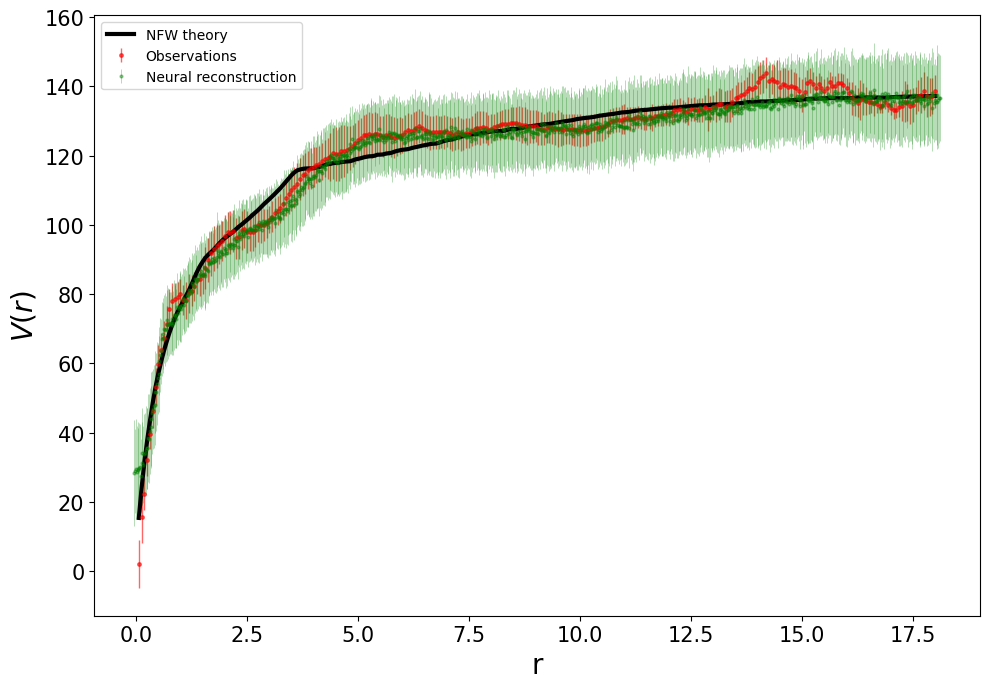

In [85]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
overlapping = 0.6
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



plt.plot(df['Radius'].values, df['Vt'].values, color='k', linewidth=3, label='NFW theory',alpha=1)

plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='red', elinewidth=1, ecolor='red', markersize=5, label='Observations', alpha=overlapping)

plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='green', capthick=2, elinewidth=0.5, alpha=overlapping-0.2, c='green',
             label='Neural reconstruction')


plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig("neural_reconstruction_RC.png", dpi=100)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

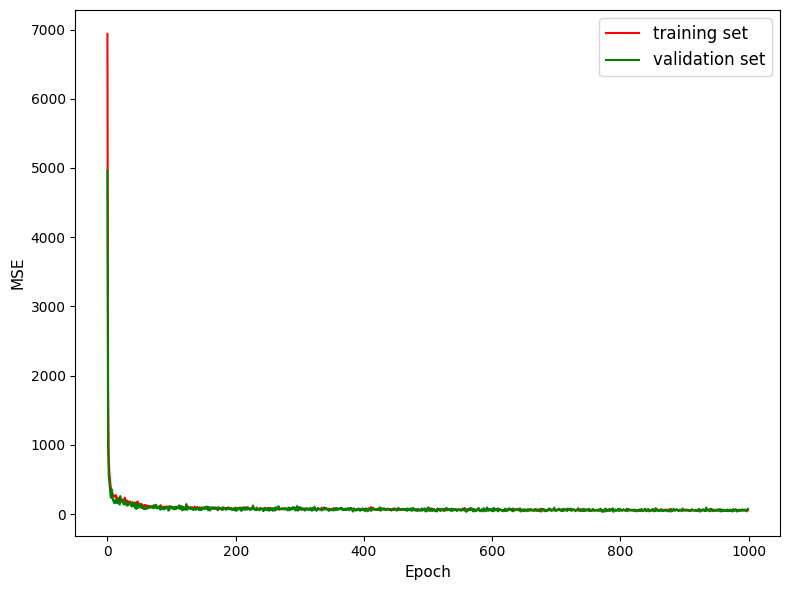

In [82]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
# plt.ylim(0, 200)